# Carsome Problem Statement 2

##### **Cars Segmentation Project - Data-driven Sourcing Strategy**

#### Project Overview
Carsome is a leading online used car marketplace that streamlines the buying and selling process for individuals through its innovative platform. To optimize their sourcing strategy, it is crucial to identify the most valuable cars to purchase within their budget and maximizes return on investment. The aim of this project is to develop a cluster model that can segment cars based on common characteristics so that Carsome can make informed decisions on which cars to source and list, rather than relying on a generic approach. 

#### Project Info
Kernel used: Python 3.8 AzureML   
Compute Instance: 2 Cores, 16 GB (RAM), 20 GB (Disk), $0.13/hr 

#### Dataset Information
-   **`lead_id`**   
	- unique identifier for sellers who opt to sell their car. 
	- In other words, the car that dealers are bidding for in the auction 
-   **`marketplace_id`**    
	- unique identifier for the auction session 
-   **`marketplace_car_id`**    
	- the unique identifier for a car that goes to a auction session.   
	- Eg. if the same lead goes to 3 auctions maybe because they weren't able to sell the car in the previous auctions, there will be 3 of the same lead_id but different marketplace_car_id. 
-   **`dealer_id`**    
	- unique identifiers for individual dealers bidding for the car 
-   **`used_dealer_company_id`**    
	- unique identified for the company the dealer is tied to? Eg, 3 dealers can be from 1 company (have the sample dealer_id). 
-   **`car_brand`**  
	- The brand of the car (e.g. Honda, Suzuki)
-   **`car_model`**
	- The model of the car (e.g. Freed, City, Ertiga)
-   **`car_variant`**
	-  The variant of the car(e.g. S, GL, VTEC)
-   **`car_engine`**
	- The size of the car's engine (e.g. 1.5, 1.4)
-   **`car_year`**
	- The year the car was manufactured
-   **`car_transmission`**   
	- The type of transmission the car has (e.g. Auto, Manual)
-   **`reserveprice`**   
	- the starting bid price of the car in an auction   
	- The reserve price for the car listing (i.e. the minimum amount the seller is willing to accept)

#### Setup Azure Subscription and Workspace

In [1]:
subscription_id = "7d3196c6-97ad-4745-9ffb-807a8de0364b" 

#Provide values for the existing Resource Group 
resource_group = "WorkspaceRG" 

#Provide the Workspace Name and Azure Region of the Azure Machine Learning Workspace
workspace_name = "AliciaWorkspace" 
workspace_region = "southeastasia" 

In [2]:
project_folder = './Carsome'

# this is the URL to the CSV file containing the dataset
data_url = ('https://raw.githubusercontent.com/Alicia2203/CarsomePricePredict/main/Microsoft%20x%20Carsome%20Hackathon%20Auction%20Data%20Set.csv')

#### Import Required Packages

In [147]:
import logging
import os
import urllib.request

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns

import azureml.core
from azureml.core.workspace import Workspace
from azureml.core import Workspace, Datastore, Dataset
from azureml.data.azure_storage_datastore import AzureBlobDatastore
from azureml.core import Dataset

import sklearn 
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.model_selection import cross_val_score

from kmodes.kprototypes import KPrototypes
from kneed import KneeLocator
from lightgbm import LGBMClassifier
import shap
from tqdm import tqdm
import sys
import warnings
warnings.filterwarnings("ignore")

# %matplotlib inline
# pd.set_option("display.precision",2)
# np.set_printoptions(precision=3, suppress=True)
# pd.options.display.float_format = '{:.3f}'.format

# Check core SDK version number
print("SDK version:", azureml.core.VERSION)

SDK version: 1.49.0


#### Create and connect to an Azure Machine Learning Workspace

In [4]:
ws = Workspace.create(
    name = workspace_name,
    subscription_id = subscription_id,
    resource_group = resource_group, 
    location = workspace_region,
    exist_ok = True)

ws.write_config()

print('Workspace configuration succeeded')

Workspace configuration succeeded


In [5]:
ws = Workspace.from_config()

# Display a summary of the current environment 
output = {}
output['SDK version'] = azureml.core.VERSION
#output['Subscription ID'] = ws.subscription_id
output['Workspace'] = ws.name
output['Resource Group'] = ws.resource_group
output['Location'] = ws.location
output['Project Directory'] = project_folder
# pd.set_option('display.max_colwidth', -1)
pd.DataFrame(data=output, index=['']).T

,
SDK version,1.49.0
Workspace,AliciaWorkspace
Resource Group,WorkspaceRG
Location,southeastasia
Project Directory,./Carsome


#### Create Azure Machine Learning TabularDataset

In [6]:
# create project folder
if not os.path.exists(project_folder):
    os.makedirs(project_folder)

# download the dataset from data_url to the project folder
urllib.request.urlretrieve(data_url, os.path.join(project_folder, 'carsome-auction-data.csv'))

# upload dataset to default workspace datastore
datastore = ws.get_default_datastore()
datastore.upload_files(files = [os.path.join(project_folder, 'carsome-auction-data.csv')],
                       target_path = 'dataset/tabular/',
                       overwrite = True,
                       show_progress = True)

# create TabularDataset reference
dataset = Dataset.Tabular.from_delimited_files(path = [(datastore, 
                                                        'dataset/tabular/carsome-auction-data.csv')])

"datastore.upload_files" is deprecated after version 1.0.69. Please use "FileDatasetFactory.upload_directory" instead. See Dataset API change notice at https://aka.ms/dataset-deprecation.


Uploading an estimated of 1 files
Uploading ./Carsome/carsome-auction-data.csv
Uploaded ./Carsome/carsome-auction-data.csv, 1 files out of an estimated total of 1
Uploaded 1 files


In [7]:
# Convert dataset to dataframe
df_ori = dataset.to_pandas_dataframe()

# Make a copy of original dataset
df = df_ori.copy()
df

,lead_id,marketplace_id,marketplace_car_id,used_dealer_company_id,dealer_id,car_brand,car_model,car_variant,car_engine,car_year,car_transmission,reserveprice
0,928320,141263,292354,4620.0,4728,honda,freed,s,1.5,2012,Auto,85000000
1,944610,141300,299526,5033.0,5141,honda,city,vtec,1.5,2011,Auto,95000000
2,929573,141255,290464,4471.0,4579,honda,hr-v,s,1.5,2016,Auto,139000000
3,942475,141290,297815,4697.0,4805,suzuki,ertiga,gl,1.4,2016,Manual,115000000
4,926113,141273,294157,4351.0,4459,suzuki,ertiga,gx,1.4,2014,Manual,85000000
...,...,...,...,...,...,...,...,...,...,...,...,...
49995,945569,141289,297561,4247.0,4355,toyota,avanza,g,1.3,2010,Manual,70000000
49996,944351,141299,299493,1407.0,1456,honda,brio,rs,1.2,2017,Manual,408000000
49997,929363,141254,290181,3660.0,3768,toyota,kijang innova,v,2.0,2019,Auto,290000000
49998,940821,141294,298398,4378.0,4486,toyota,avanza,veloz,1.5,2017,Auto,135000000


#### Inspect Dataset

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   lead_id                 50000 non-null  int64  
 1   marketplace_id          50000 non-null  int64  
 2   marketplace_car_id      50000 non-null  int64  
 3   used_dealer_company_id  49998 non-null  float64
 4   dealer_id               50000 non-null  int64  
 5   car_brand               50000 non-null  object 
 6   car_model               50000 non-null  object 
 7   car_variant             49998 non-null  object 
 8   car_engine              49999 non-null  float64
 9   car_year                50000 non-null  int64  
 10  car_transmission        50000 non-null  object 
 11  reserveprice            50000 non-null  int64  
dtypes: float64(2), int64(6), object(4)
memory usage: 4.6+ MB


In [9]:
# Get summary statistics for all columns
df.describe(include='all')

,lead_id,marketplace_id,marketplace_car_id,used_dealer_company_id,dealer_id,car_brand,car_model,car_variant,car_engine,car_year,car_transmission,reserveprice
count,50000.000000,50000.000000,50000.000000,49998.000000,50000.000000,50000,50000,49998,49999.000000,50000.000000,50000,5.000000e+04
unique,NaN,NaN,NaN,NaN,NaN,26,189,385,NaN,NaN,2,NaN
top,NaN,NaN,NaN,NaN,NaN,toyota,kijang innova,g,NaN,NaN,Auto,NaN
freq,NaN,NaN,NaN,NaN,NaN,18584,3827,6349,NaN,NaN,36366,NaN
mean,925272.445800,141275.731960,294754.805920,3926.824093,4021.263740,NaN,NaN,NaN,1.814302,2014.315880,NaN,1.659316e+08
std,82672.275461,15.859356,3251.558522,1355.540868,1380.611447,NaN,NaN,NaN,0.526659,4.020739,NaN,1.254980e+08
min,82713.000000,141247.000000,288540.000000,190.000000,176.000000,NaN,NaN,NaN,1.000000,1989.000000,NaN,1.500000e+06
25%,929838.500000,141261.000000,292012.000000,3362.000000,3456.000000,NaN,NaN,NaN,1.500000,2012.000000,NaN,8.950000e+07
50%,937556.000000,141277.000000,295147.000000,4330.000000,4438.000000,NaN,NaN,NaN,1.500000,2015.000000,NaN,1.300000e+08
75%,943577.000000,141289.000000,297561.000000,4900.000000,5008.000000,NaN,NaN,NaN,2.200000,2017.000000,NaN,2.000000e+08


In [10]:
# Get Unique Values for each columns

for column in df.columns:
    # Get the number of unique values in the column
    unique_values = df[column].nunique()
    # Print the column name and number of unique values
    print(f"'{column}' - {unique_values} ")

'lead_id' - 4498 
'marketplace_id' - 55 
'marketplace_car_id' - 5686 
'used_dealer_company_id' - 776 
'dealer_id' - 1131 
'car_brand' - 26 
'car_model' - 189 
'car_variant' - 385 
'car_engine' - 29 
'car_year' - 31 
'car_transmission' - 2 
'reserveprice' - 484 


##### Remove Duplicate Rows 
First we observe if there are any duplicates based on ALL columns

In [11]:
#Find the number of duplicates based on ALL columns
df.duplicated().sum()

3661

There are a total of 3661 duplicate rows (except first occurrence based on all columns ).

Before removing the duplicated rows, we shall observe all the duplicated rows.

In [12]:
# view duplicate row based on all columns
duplicates = df[df.duplicated(keep=False)]
duplicates = duplicates.sort_values('lead_id')
duplicates

,lead_id,marketplace_id,marketplace_car_id,used_dealer_company_id,dealer_id,car_brand,car_model,car_variant,car_engine,car_year,car_transmission,reserveprice
18695,204498,141288,297381,4279.0,4387,mitsubishi,pajero sport,exceed,2.5,2015,Auto,265000000
40207,204498,141288,297381,4279.0,4387,mitsubishi,pajero sport,exceed,2.5,2015,Auto,265000000
1548,204498,141288,297381,4279.0,4387,mitsubishi,pajero sport,exceed,2.5,2015,Auto,265000000
23020,266913,141271,293825,4279.0,4387,honda,hr-v,prestige,1.8,2015,Auto,200000000
17728,266913,141271,293825,4279.0,4387,honda,hr-v,prestige,1.8,2015,Auto,200000000
...,...,...,...,...,...,...,...,...,...,...,...,...
5007,951034,141300,299579,5628.0,5736,mitsubishi,pajero,d exceed,2.5,2014,Auto,195000000
37612,951034,141300,299579,4461.0,4569,mitsubishi,pajero sport,dakar,2.5,2014,Auto,195000000
13011,951034,141300,299579,4461.0,4569,mitsubishi,pajero,d exceed,2.5,2014,Auto,195000000
15407,951034,141300,299579,4461.0,4569,mitsubishi,pajero,d exceed,2.5,2014,Auto,195000000


In [13]:
# remove duplicates and keep the first occurrence
df.drop_duplicates(inplace=True)

df.shape

(46339, 12)

3661 duplicate rows have been removed, we are left with 46339 rows.   

After that, we are interested to know **if there exists 2 same cars** in the dataset. Since lead_id identifies the seller and marketplace_car_id identifies the car that goes to a particular auction session. We can assume that no two cars will have the same **lead_id** and **marketplace_car_id** combination in this dataset.

In [14]:
# Get list of duplicate rows based on 'lead_id','marketplace_car_id' column
car_duplicate = df[df.duplicated(['lead_id','marketplace_car_id'], keep=False)]
car_duplicate = car_duplicate.sort_values('marketplace_car_id')
car_duplicate

,lead_id,marketplace_id,marketplace_car_id,used_dealer_company_id,dealer_id,car_brand,car_model,car_variant,car_engine,car_year,car_transmission,reserveprice
1255,926738,141247,288541,5446.0,5554,honda,jazz,rs,1.5,2018,Auto,168000000
36618,926738,141247,288541,4637.0,4745,chevrolet,trax,turbo premier,1.4,2018,Auto,168000000
41880,926738,141247,288541,1398.0,1447,chevrolet,trax,turbo premier,1.4,2018,Auto,168000000
38108,923167,141247,288546,4873.0,4981,suzuki,carry,pick up,1.5,2019,Manual,80000000
21798,923167,141247,288546,5441.0,5549,honda,brio,rs,1.2,2019,Manual,140000000
...,...,...,...,...,...,...,...,...,...,...,...,...
42725,946661,141301,299902,1101.0,1149,volkswagen,tiguan,tsi,1.4,2019,Auto,410000000
33908,946661,141301,299902,4678.0,4786,volkswagen,tiguan,tsi allspace,1.4,2019,Auto,410000000
18714,946661,141301,299902,4336.0,4444,volkswagen,tiguan,tsi,1.4,2019,Auto,410000000
41861,946661,141301,299902,3738.0,3846,volkswagen,tiguan,tsi allspace,1.4,2019,Auto,410000000


However, as seen in the first 2 observations (index number: 1255, 36618), **lead_id** and **marketplace_car_id** cannot uniquely identify each car.

As such, we will be using **lead_id**, **marketplace_car_id**, **car_brand**, **car_model**, **car_variant**, **car_engine**, **car_year** and **car_transmission** as the unique identifier for each car in this dataset. 

In [15]:
# remove duplicates and keep the first occurrence
df.drop_duplicates(['lead_id','marketplace_car_id', 
                    'car_brand', 'car_model', 'car_variant', 
                    'car_engine', 'car_transmission'],inplace=True)

df.sort_values(['marketplace_car_id','lead_id','car_brand'])

,lead_id,marketplace_id,marketplace_car_id,used_dealer_company_id,dealer_id,car_brand,car_model,car_variant,car_engine,car_year,car_transmission,reserveprice
16732,926047,141247,288540,4378.0,4486,honda,hr-v,a,1.5,2015,Auto,170000000
36618,926738,141247,288541,4637.0,4745,chevrolet,trax,turbo premier,1.4,2018,Auto,168000000
1255,926738,141247,288541,5446.0,5554,honda,jazz,rs,1.5,2018,Auto,168000000
36675,917431,141247,288542,4471.0,4579,honda,accord,vti-l,2.4,2005,Auto,50000000
48020,923167,141247,288543,5073.0,5181,nissan,livina,el,1.5,2019,Manual,140000000
...,...,...,...,...,...,...,...,...,...,...,...,...
36567,946661,141301,299902,4284.0,4392,honda,hr-v,e plus,1.5,2019,Auto,180000000
111,946661,141301,299902,4296.0,4404,volkswagen,tiguan,tsi,1.4,2019,Auto,410000000
628,946661,141301,299902,4177.0,4285,volkswagen,tiguan,tsi allspace,1.4,2019,Auto,410000000
37111,946661,141301,299902,1398.0,1447,volkswagen,tiguan,tsi trd,1.4,2019,Auto,410000000


We are now left with a total of 30381 observations, assuming that each observation consists of a unique car.

Based on looking at columns lead_id, marketplace_car_id, car_brand, car_model, car_variant, car_engine, car_year and car_transmission, all cars seems to be unique.

#### Data Preparation

##### Derive feature car_age
Car age is derived from car year to calculate the age of each car in the dataset. This feature can be useful in cluster analysis to identify groups of cars based on their age

In [23]:
# Derive feature car_age from car_year 
df['car_age'] = 2023 - df['car_year']

df = df.drop(['car_year'], axis=1)

df.head()

,lead_id,marketplace_id,marketplace_car_id,used_dealer_company_id,dealer_id,car_brand,car_model,car_variant,car_engine,car_transmission,reserveprice,car_age
0,928320,141263,292354,4620.0,4728,honda,freed,s,1.5,Auto,85000000,11
1,944610,141300,299526,5033.0,5141,honda,city,vtec,1.5,Auto,95000000,12
2,929573,141255,290464,4471.0,4579,honda,hr-v,s,1.5,Auto,139000000,7
3,942475,141290,297815,4697.0,4805,suzuki,ertiga,gl,1.4,Manual,115000000,7
4,926113,141273,294157,4351.0,4459,suzuki,ertiga,gx,1.4,Manual,85000000,9


##### Derive feature brand_price_tier
The purpose of creating the brand_price_tier feature is to assign a label to each car brand based on its average reserve price, which serves as an indicator of the brand's perceived level of luxury. This is achieved by first calculating the average reserve price for each car brand and then dividing the brands into three equal-sized bins, with labels of 'low', 'medium', and 'high' based on their respective average reserve prices. The resulting brand_price_tier column is added to the DataFrame as a new feature for further analysis and modeling.

In [24]:
# calculate the average reserve price for each car brand
brand_prices = df.groupby('car_brand')['reserveprice'].mean()
brand_prices

car_brand
audi             1.500469e+08
bmw              2.152660e+08
chevrolet        1.426027e+08
daihatsu         8.759311e+07
datsun           6.363800e+07
ford             7.804259e+07
fordta           1.040000e+08
honda            1.397018e+08
hyundai          1.139816e+08
isuzu            1.391946e+08
kia              1.828729e+08
land rover       4.000000e+08
mazda            1.648987e+08
mercedes-benz    2.802326e+08
mini             4.168085e+08
mitsubishi       2.100803e+08
nissan           8.761534e+07
ota              4.950000e+07
peugeot          4.813636e+07
renault          1.132273e+08
subaru           8.708333e+07
suzuki           8.768255e+07
tata             8.000000e+07
toyota           1.532789e+08
volkswagen       2.513687e+08
wuling           1.249691e+08
Name: reserveprice, dtype: float64

In [25]:
# label the car brands based on their average reserve price
tier_labels = pd.qcut(brand_prices, 3, labels=['low', 'medium', 'high'])
tier_labels

car_brand
audi             medium
bmw                high
chevrolet        medium
daihatsu            low
datsun              low
ford                low
fordta           medium
honda            medium
hyundai          medium
isuzu            medium
kia                high
land rover         high
mazda              high
mercedes-benz      high
mini               high
mitsubishi         high
nissan              low
ota                 low
peugeot             low
renault          medium
subaru              low
suzuki              low
tata                low
toyota             high
volkswagen         high
wuling           medium
Name: reserveprice, dtype: category
Categories (3, object): ['low' < 'medium' < 'high']

In [26]:
# add a new column to the DataFrame with the brand price tier labels
df['brand_price_tier'] = df['car_brand'].map(tier_labels)
df.head()

,lead_id,marketplace_id,marketplace_car_id,used_dealer_company_id,dealer_id,car_brand,car_model,car_variant,car_engine,car_transmission,reserveprice,car_age,brand_price_tier
0,928320,141263,292354,4620.0,4728,honda,freed,s,1.5,Auto,85000000,11,medium
1,944610,141300,299526,5033.0,5141,honda,city,vtec,1.5,Auto,95000000,12,medium
2,929573,141255,290464,4471.0,4579,honda,hr-v,s,1.5,Auto,139000000,7,medium
3,942475,141290,297815,4697.0,4805,suzuki,ertiga,gl,1.4,Manual,115000000,7,low
4,926113,141273,294157,4351.0,4459,suzuki,ertiga,gx,1.4,Manual,85000000,9,low


##### Derive feature car_type

To get more information from our existing dataset, we decided to derive **car_type** feature. 

car_type feature consists of manually human labeled values and automatically labeled values with the help of **ChatGPT**. 

A dataset which consists of each car_brand and car_model in this dataset is exported for the purpose of labeling the car type.

In [27]:
brand_model = df.groupby(['car_brand', 'car_model'])['car_model'].count()
brand_model

car_brand  car_model
audi       3              1
           a4             9
           a6            19
           a7             3
bmw        1              1
                       ... 
wuling     c              1
           confero      276
           cortez       130
           jazz           1
           mobilio        1
Name: car_model, Length: 325, dtype: int64

In [28]:
# export brand_model to a csv file
brand_model.to_csv(os.path.join(project_folder, 'brand_model.csv'), index=True)

The dataset was fed into ChatGPT and we prompted ChatGPT to label each the car_types of each car based on their brands and model. However, given that ChatGPT is not always accurate, humans are required to manually fact check the output data.

We categorized the cars into 9 **car types**:
- Sedan
- SUV
- MPV
- Hatchback
- Coupe
- Electric
- Truck
- Wagon
- Convertible
- Van


After labeling each car with its car_type, we upload the dataset to the default workspace datastore so that I can be merged into the original dataset.

In [ ]:
data_url2 = ('https://raw.githubusercontent.com/Alicia2203/CarsomeCarsSegmentation/main/Brand_Model_CarType.csv')

In [29]:
# download the dataset from data_url to the project folder
urllib.request.urlretrieve(data_url2, os.path.join(project_folder, 'Brand_Model_CarType.csv'))

# upload dataset to default workspace datastore
datastore = ws.get_default_datastore()
datastore.upload_files(files = [os.path.join(project_folder, 'Brand_Model_CarType.csv')],
                       target_path = 'dataset/tabular/',
                       overwrite = True,
                       show_progress = True)

# create TabularDataset reference
dataset2 = Dataset.Tabular.from_delimited_files(path = [(datastore, 
                                                        'dataset/tabular/Brand_Model_CarType.csv')])

Uploading an estimated of 1 files
Uploading ./Carsome/Brand_Model_CarType.csv
Uploaded ./Carsome/Brand_Model_CarType.csv, 1 files out of an estimated total of 1
Uploaded 1 files


In [30]:
# Convert dataset to dataframe
df2 = dataset2.to_pandas_dataframe()
df2

,car_brand,car_model,car_type
0,audi,3,Sedan
1,audi,a4,Sedan
2,audi,a6,Sedan
3,audi,a7,Sedan
4,bmw,1,Sedan
...,...,...,...
320,wuling,c,MPV
321,wuling,confero,MPV
322,wuling,cortez,MPV
323,wuling,jazz,MPV


In [31]:
# View unique car types
df2['car_type'].unique()

array(['Sedan', 'Hatchback', 'SUV', 'Van', 'MPV', 'Convertible', 'Truck',
       'Coupe', 'Electric', 'Wagon'], dtype=object)

In [32]:
# Merge datasets based on car_brand and car_model
df_merged = pd.merge(df, df2, on=['car_brand', 'car_model'], how='left')

df_merged

,lead_id,marketplace_id,marketplace_car_id,used_dealer_company_id,dealer_id,car_brand,car_model,car_variant,car_engine,car_transmission,reserveprice,car_age,brand_price_tier,car_type
0,928320,141263,292354,4620.0,4728,honda,freed,s,1.5,Auto,85000000,11,medium,MPV
1,944610,141300,299526,5033.0,5141,honda,city,vtec,1.5,Auto,95000000,12,medium,Sedan
2,929573,141255,290464,4471.0,4579,honda,hr-v,s,1.5,Auto,139000000,7,medium,SUV
3,942475,141290,297815,4697.0,4805,suzuki,ertiga,gl,1.4,Manual,115000000,7,low,MPV
4,926113,141273,294157,4351.0,4459,suzuki,ertiga,gx,1.4,Manual,85000000,9,low,MPV
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30376,919992,141248,288939,4385.0,4493,toyota,yaris,e,1.5,Auto,143000000,10,high,Hatchback
30377,938295,141271,293751,4605.0,4713,honda,br-v,e prestige,1.5,Auto,150000000,6,medium,SUV
30378,948903,141298,299288,5628.0,5736,nissan,evalia,st,1.5,Auto,89000000,9,low,Van
30379,944351,141299,299493,1407.0,1456,honda,brio,rs,1.2,Manual,408000000,6,medium,Hatchback


#### Deal with Missing Values

In [34]:
# Checking for Missing Values
count_missing = df_merged.isnull().sum() 
percent_missing = (df_merged.isnull().sum()/len(df))*100
missing_values = pd.concat([percent_missing,count_missing], axis=1,
                           keys=['Percent_of_Missing_Values', 'Count_of_Missing_Values'])
missing_values

,Percent_of_Missing_Values,Count_of_Missing_Values
lead_id,0.000000,0
marketplace_id,0.000000,0
marketplace_car_id,0.000000,0
used_dealer_company_id,0.003292,1
dealer_id,0.000000,0
car_brand,0.000000,0
car_model,0.000000,0
car_variant,0.006583,2
car_engine,0.003292,1
car_transmission,0.000000,0


It is observed that there are null values for used_dealer_company_id, car_variant and car_engine. 

However, since we are not interested in using used_dealer_company_id and car_variant feature for cluster analysis, we shall only be dealing with the null value in car_engine.

The null value in car_engine is replaced by the mode value of column car_engine.

In [35]:
# checking the value which is Null for car_engine
df_merged[df_merged['car_engine'].isnull()]

,lead_id,marketplace_id,marketplace_car_id,used_dealer_company_id,dealer_id,car_brand,car_model,car_variant,car_engine,car_transmission,reserveprice,car_age,brand_price_tier,car_type
11224,937374,141271,293784,5628.0,5736,toyota,camry,v,NaN,Manual,35000000,13,high,Sedan


In [36]:
# Fill missing values
df_merged['car_engine'].fillna(df_merged['car_engine'].mode()[0], inplace=True)

#### Exploratory Data Analysis (EDA)

ID features namely **lead_id**, **marketplace_id**, **marketplace_car_id**, **dealer_id** and **used_dealer_company_id** are excluded from the EDA since they don't bring much value for building our cluster model.

##### Univariate Analysis

###### Numerical Featuers

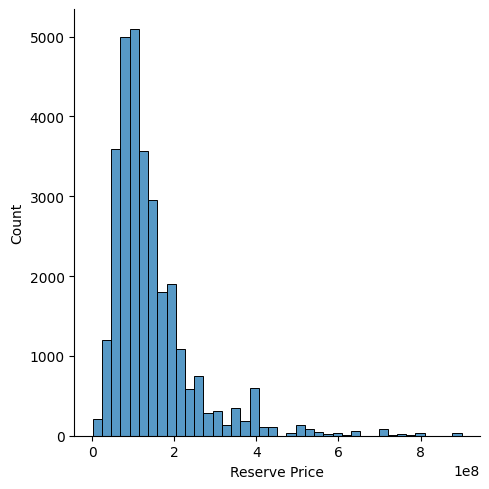

In [37]:
# Create a histogram of the reserve prices
sns.displot(df_merged, x="reserveprice", bins=40)
plt.xlabel('Reserve Price')
plt.ylabel('Count')
plt.show()

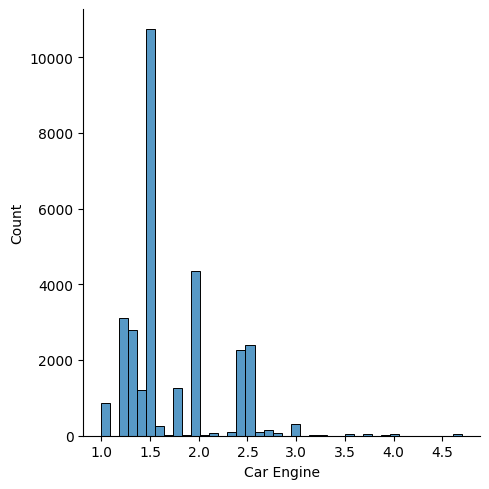

In [38]:
# Create a histogram of the car engine
sns.displot(df_merged, x="car_engine", bins=40)
plt.xlabel('Car Engine')
plt.ylabel('Count')
plt.show()

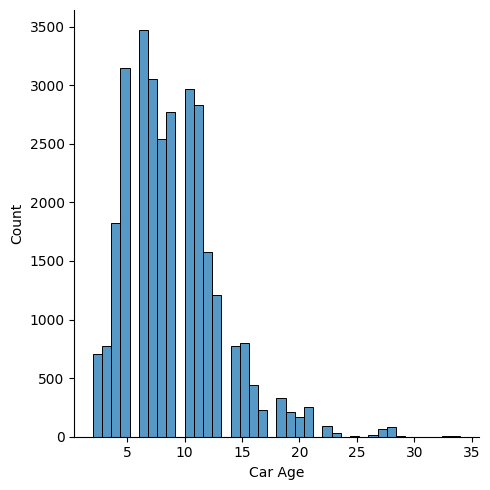

In [165]:
# Create a histogram of the car age
sns.displot(df_merged, x="car_age", bins=40)
plt.xlabel('Car Age')
plt.ylabel('Count')
plt.show()

##### Categorical Variables

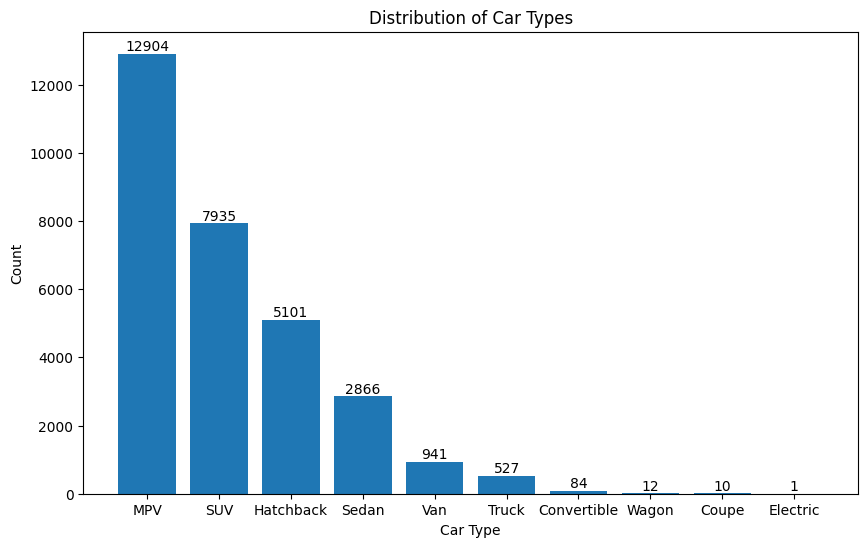

In [40]:
# Count the occurrences of each category
counts = df_merged['car_type'].value_counts()

# Create a bar chart
plt.figure(figsize=(10,6))
plt.bar(counts.index, counts.values)
plt.title('Distribution of Car Types')
plt.xlabel('Car Type')
plt.ylabel('Count')

# Add data labels to the bars
for i, v in enumerate(counts.values):
    plt.text(i, v, str(v), ha='center', va='bottom')

plt.show()

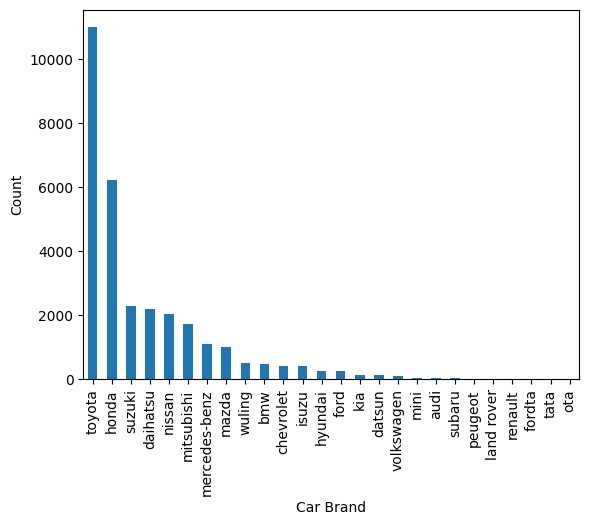

In [41]:
# Create a bar chart of the car brands
df_merged['car_brand'].value_counts().plot(kind='bar')
plt.xlabel('Car Brand')
plt.ylabel('Count')
plt.show()

The most popular brand is Toyota, followed by Honda.

##### Bivariate Analysis

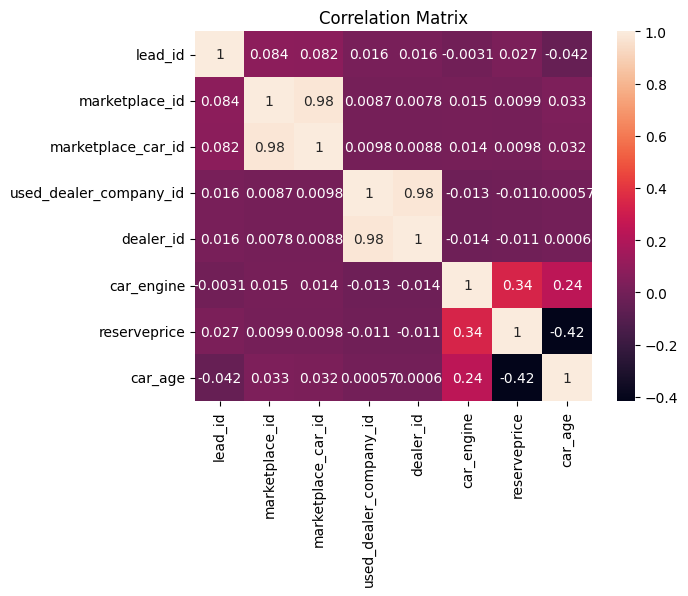

In [166]:
# Create a correlation matrix of the numeric columns
df_corr = df_merged.copy()

corr = df_corr.corr()
sns.heatmap(corr, annot=True)
plt.title('Correlation Matrix')
plt.show()


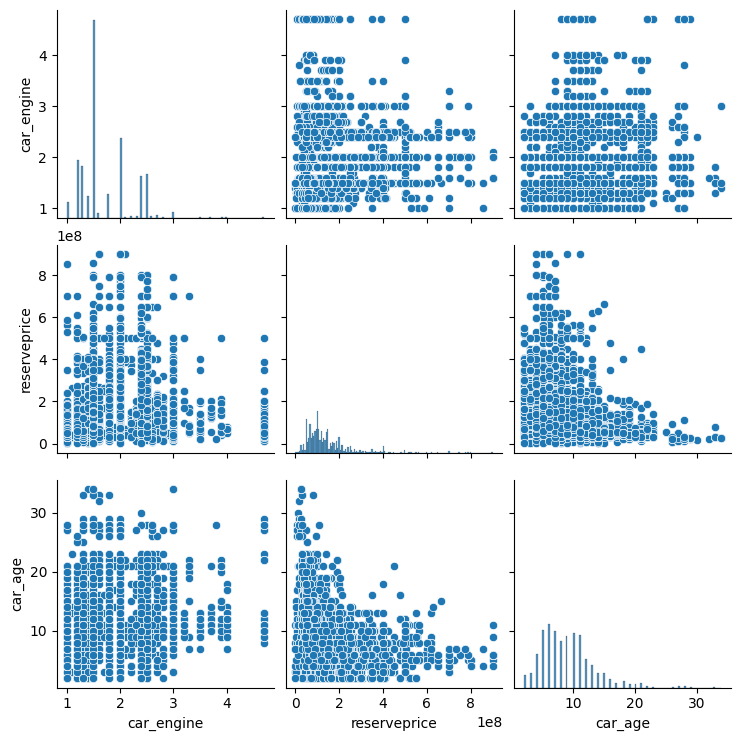

In [168]:
df_corr = df_corr.drop(['lead_id', 'marketplace_id', 'marketplace_car_id',
                         'used_dealer_company_id', 'dealer_id'], axis=1)

# Create a pair plot of the numeric columns
sns.pairplot(df_corr)
plt.show()

Based on the correlation matrix and pairplots above, it is observed that
- there is a negative correlation between reserveprice and car_age, which makes sense!
- there seems to be a weak positive correlation between reserveprice and car_engine.
- there seems to be a weak correlation between car_age and car_engine.

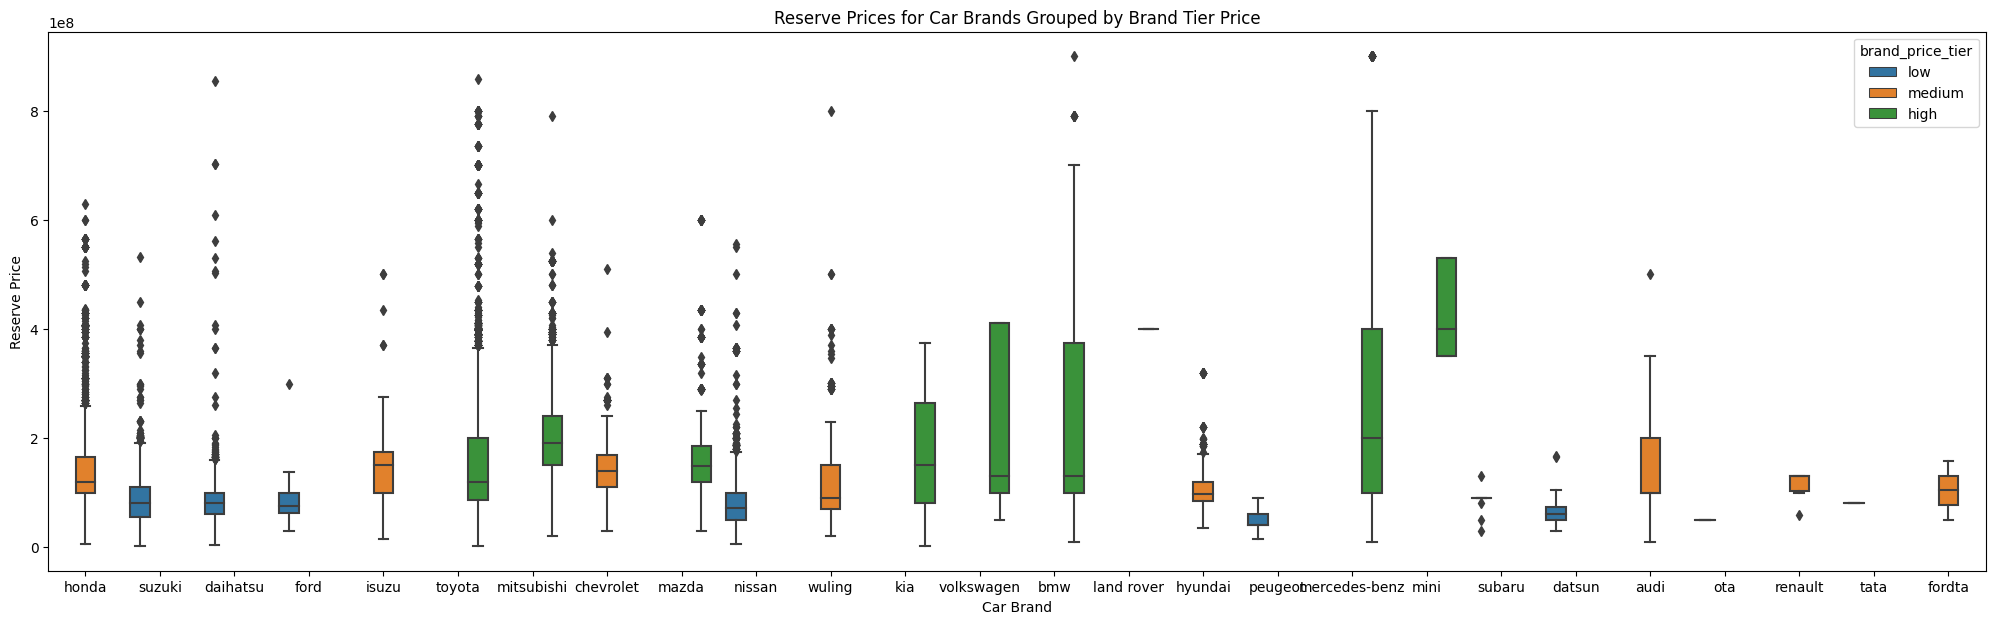

In [164]:
# Set the size of the figure
plt.figure(figsize=(25, 7))

# Create a box plot of the reserve prices for each car brand
sns.boxplot(x='car_brand', y='reserveprice', hue='brand_price_tier', data=df_merged)
plt.xlabel('Car Brand')
plt.ylabel('Reserve Price')
plt.title('Reserve Prices for Car Brands Grouped by Brand Tier Price')
plt.show()

In [ ]:

# Histogram of income by gender
plt.hist('reserveprice', data=df_merged[df_merged['car_transmission'] == 'Auto'], alpha=0.5, label='Auto', bins=40);
plt.hist('reserveprice', data=df_merged[df_merged['car_transmission'] == 'Manual'], alpha=0.5, label='Manual');
plt.title('Distribution of Income by car_transmission');
plt.xlabel('reserveprice');
plt.legend();

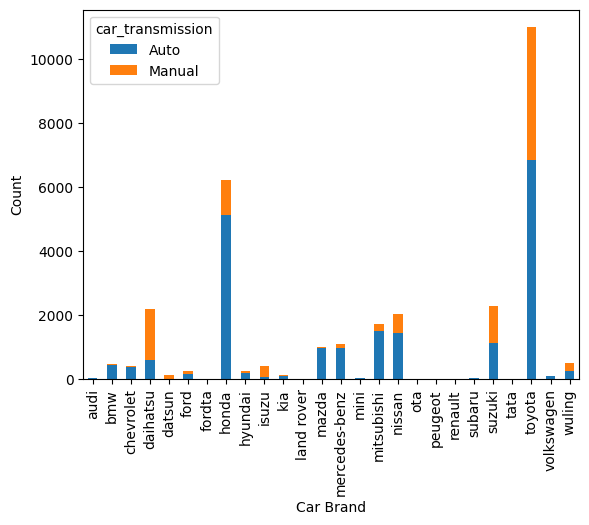

In [46]:
# Create a bar chart of the car brands and transmissions
df_merged.groupby(['car_brand', 'car_transmission']).size().unstack().plot(kind='bar', stacked=True)
plt.xlabel('Car Brand')
plt.ylabel('Count')
plt.show()

##### Conclusions from EDA
- 

#### Feature Selection

The goal of this project is to build a cluster model to segment cars.

Cluster analysis is a method used to group similar objects or observations based on their attributes or characteristics. Therefore, variables that are suitable for cluster analysis are those that can effectively differentiate or distinguish the objects or observations being clustered.


In [47]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30381 entries, 0 to 30380
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   lead_id                 30381 non-null  int64   
 1   marketplace_id          30381 non-null  int64   
 2   marketplace_car_id      30381 non-null  int64   
 3   used_dealer_company_id  30380 non-null  float64 
 4   dealer_id               30381 non-null  int64   
 5   car_brand               30381 non-null  object  
 6   car_model               30381 non-null  object  
 7   car_variant             30379 non-null  object  
 8   car_engine              30381 non-null  float64 
 9   car_transmission        30381 non-null  object  
 10  reserveprice            30381 non-null  int64   
 11  car_age                 30381 non-null  int64   
 12  brand_price_tier        30381 non-null  category
 13  car_type                30381 non-null  object  
dtypes: category(1), float6

- **_Numerical_** columns **lead_id**, **marketplace_id**, **marketplace_car_id**, **used_dealer_company_id** and **dealer_id** which contains thousands of unique values, is meaningless for clustering. Therefore we exclude them from our dataset.   

- **_Categorical_** columns **car_brand**, **car_model** and **car_variant** consists of too many unique values are not suitable for cluster analysis because they tend to create sparse data points, which can lead to less meaningful clusters. Therefore we exclude them from our dataset as well.  

In [48]:
# create a subset of selected columns from the dataset for building our cluster model
df_select = df_merged[['car_engine', 'reserveprice', 'car_age', 'car_transmission', 'brand_price_tier', 'car_type']]
df_select.head()

,car_engine,reserveprice,car_age,car_transmission,brand_price_tier,car_type
0,1.5,85000000,11,Auto,medium,MPV
1,1.5,95000000,12,Auto,medium,Sedan
2,1.5,139000000,7,Auto,medium,SUV
3,1.4,115000000,7,Manual,low,MPV
4,1.4,85000000,9,Manual,low,MPV


In [49]:
# 
df_select["reserveprice"] = df_select["reserveprice"].astype(np.float64)
df_select["car_age"] = df_select["car_age"].astype(np.float64)
df_select["brand_price_tier"] = df_select["brand_price_tier"].astype(object)

In [50]:
# unique categorical elements per column
print(df_select.select_dtypes("object").nunique())

# numerical variables
df_select.select_dtypes(exclude='object').describe()

car_transmission     2
brand_price_tier     3
car_type            10
dtype: int64


,car_engine,reserveprice,car_age
count,30381.000000,3.038100e+04,30381.000000
mean,1.716059,1.442640e+08,8.885191
std,0.492091,1.066576e+08,4.165043
min,1.000000,1.500000e+06,2.000000
25%,1.400000,8.000000e+07,6.000000
50%,1.500000,1.150000e+08,8.000000
75%,2.000000,1.700000e+08,11.000000
max,4.700000,9.000000e+08,34.000000


#### Preprocess Numerical Features

In [155]:
# Make a copy of the dataset before Normalizing the data
df_cluster = df_select.copy()

In [156]:
# 
df_num_col = list(df_cluster.dtypes[df_cluster.dtypes == "float64"].index)
df_cluster[df_num_col].head()

,car_engine,reserveprice,car_age
0,1.5,85000000.0,11.0
1,1.5,95000000.0,12.0
2,1.5,139000000.0,7.0
3,1.4,115000000.0,7.0
4,1.4,85000000.0,9.0


In [157]:
scaler = StandardScaler()
df_cluster[df_num_col] = scaler.fit_transform(df_cluster[df_num_col])
df_cluster[df_num_col].head() 

,car_engine,reserveprice,car_age
0,-0.439071,-0.555656,0.507760
1,-0.439071,-0.461897,0.747858
2,-0.439071,-0.049355,-0.452630
3,-0.642288,-0.274378,-0.452630
4,-0.642288,-0.555656,0.027565


In [158]:
df_cluster.describe()

,car_engine,reserveprice,car_age
count,3.038100e+04,3.038100e+04,3.038100e+04
mean,3.300996e-16,1.120587e-15,3.505310e-16
std,1.000016e+00,1.000016e+00,1.000016e+00
min,-1.455159e+00,-1.338548e+00,-1.653117e+00
25%,-6.422885e-01,-6.025359e-01,-6.927273e-01
50%,-4.390708e-01,-2.743775e-01,-2.125323e-01
75%,5.770175e-01,2.413000e-01,5.077603e-01
max,6.063894e+00,7.085747e+00,6.030003e+00


In [159]:
# get indices of category columns
catcol_idx = [df_cluster.columns.get_loc(col) for col in list(df_cluster.select_dtypes("object").columns)]
catcol_idx

[3, 4, 5]

#### Clustering - K-Prototype

In [56]:
# kPrototypes (first guessing 4 clusters)
kproto4 = KPrototypes(n_clusters = 4, init='Cao', n_jobs = 4)
res4 = kproto4.fit_predict(df_cluster, categorical=catcol_idx)
kproto4.cost_

In [160]:
# 
pd.Series(res4).value_counts()

0    14217
2     6670
1     6409
3     3085
dtype: int64

##### Elbow Plot with Cost

In [161]:
# kprototypes: looking for the elbow - compare number of clusters by their cost
# cost = sum distance of all points to their respective cluster centroids

# run kPrototypes for alternative number of clusters k
dict_cost_c3 = {}
for k in tqdm(range(2,10)):
    kproto = KPrototypes(n_clusters=k, init='Cao', n_jobs=4, verbose=2)
    res = kproto.fit_predict(df_cluster, categorical=catcol_idx)
    dict_cost_c3[k] = kproto.cost_


 25%|██▌       | 2/8 [22:18<1:06:36, 666.15s/it]

Initialization method and algorithm are deterministic. Setting n_init to 1.
Best run was number 10
Initialization method and algorithm are deterministic. Setting n_init to 1.
Best run was number 2
Initialization method and algorithm are deterministic. Setting n_init to 1.


In [62]:
print("cost (sum distance) for all k:")
_ = [print(k,":",f'{v:.3f}') for k,v in dict_cost_c3.items()]

cost (sum distance) for all k:
2 : 83232.423
3 : 63434.719
4 : 53504.193
5 : 46745.923
6 : 43126.569
7 : 39964.544
8 : 37451.384
9 : 35362.906


In [169]:
# scree plot: look for elbow
plt.figure(figsize=[8,5])
plt.plot(dict_cost_c3.keys(), dict_cost_c3.values(), color="blue")
plt.title("cost (sum distance) vs. number of clusters")
plt.xticks(np.arange(2,10,1))
plt.xlabel("number of clusters K")
plt.ylabel("cost");

TypeError: float() argument must be a string or a number, not 'dict_keys'

#### KneeLocator

In [65]:
# cost (sum distance): confirm visual clue of elbow plot
# KneeLocator class will detect elbows if curve is convex; if concave, will detect knees
cost_knee_c3 = KneeLocator(
        x=list(dict_cost_c3.keys()), 
        y=list(dict_cost_c3.values()), 
        S=0.1, curve="convex", direction="decreasing", online=True)

K_cost_c3 = cost_knee_c3.elbow   
print("elbow at k =", f'{K_cost_c3:.0f} clusters')

elbow at k = 4 clusters


#### Insert Cluster Label  

In [66]:
# kPrototypes with clusters determined by elbow method
df_labeled = df_select.copy()

df_labeled.insert(0, "Cluster", res4)  
df_labeled

,Cluster,car_engine,reserveprice,car_age,car_transmission,brand_price_tier,car_type
0,1,1.5,85000000.0,11.0,Auto,medium,MPV
1,1,1.5,95000000.0,12.0,Auto,medium,Sedan
2,0,1.5,139000000.0,7.0,Auto,medium,SUV
3,0,1.4,115000000.0,7.0,Manual,low,MPV
4,1,1.4,85000000.0,9.0,Manual,low,MPV
...,...,...,...,...,...,...,...
30376,0,1.5,143000000.0,10.0,Auto,high,Hatchback
30377,0,1.5,150000000.0,6.0,Auto,medium,SUV
30378,0,1.5,89000000.0,9.0,Auto,low,Van
30379,3,1.2,408000000.0,6.0,Manual,medium,Hatchback


0    14217
2     6670
1     6409
3     3085
Name: Cluster, dtype: int64


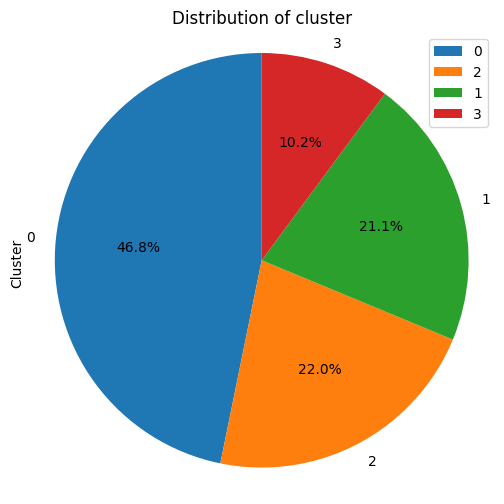

In [67]:
# size of clusters
# Count the occurrences of each category
counts = df_labeled['Cluster'].value_counts()
print(counts)

# Create a pie chart
plt.figure(figsize=(6,6))
counts.plot.pie(autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Distribution of cluster')
plt.legend()
plt.show()

#### Cluster Profile

In [152]:
# Summary Statistics for numerical variables grouped by Clusters
df_labeled.groupby('Cluster').describe().T.style.format('{:.2f}')

In [143]:
# helper function: pie charts for categorical variables and histogram charts for numerical variables
def cluster_pies(df):
    
    # number of variables
    c = df.shape[1]
    
    # number of clusters
    K = df["Cluster"].nunique()

    for k in tqdm(range(K)):
        dfc = df[df["Cluster"]==k]

        price = dfc["reserveprice"].median()
        age = dfc["car_age"].median()
        engine = dfc["car_engine"].median()

        # Number of cars
        cars = dfc.shape[0]

        fig = plt.figure(figsize=(40, 10))
        fig.suptitle("Cluster " + str(k) + ": " + \
            f'{cars:,.0f}' + " cars | " + \
            "Median Reserve Price " + f'{price:.2f}' + \
            " | Median Car Age " + f'{age:.0f}' + \
            " | Median Car Engine " + f'{engine:.2f}', 
            fontsize=16)

        # Pie Chart for Categorical Variables
        ax1 = plt.subplot2grid((2, c), (0, 0))
        plt.pie(dfc["car_type"].value_counts(), labels= dfc["car_type"].unique(), autopct='%1.1f%%')
        plt.title("car_type");

        ax1 = plt.subplot2grid((2,c),(0,1))
        plt.pie(dfc["car_transmission"].value_counts(), labels=dfc["car_transmission"].unique(), autopct='%1.1f%%')
        plt.title("car_transmission");
        
        ax1 = plt.subplot2grid((2,c),(0,2))
        plt.pie(dfc["brand_price_tier"].value_counts(), labels=dfc["brand_price_tier"].unique(), autopct='%1.1f%%')
        plt.title("brand_price_tier");
        
        # Histogram Plot for Numerical Variables
        ax1 = plt.subplot2grid((2,c),(0,3))
        plt.hist(dfc['reserveprice'], weights=np.ones(len(dfc)) / len(dfc),  bins=20, alpha=0.5)
        plt.title("Reserve Price")
        plt.ylabel('Percentage')
        plt.xlim(left=0, right=1000000000)
        plt.ylim(bottom=0)
        plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
        ;

        ax1 = plt.subplot2grid((2,c),(0,4))
        plt.hist(dfc['car_age'], weights=np.ones(len(dfc)) / len(dfc),  bins=20, alpha=0.5)
        plt.title("Car Age")
        plt.ylabel('Percentage')
        plt.xlim(left=0, right=30)
        plt.ylim(bottom=0)
        plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
        ;

        ax1 = plt.subplot2grid((2,c),(0,5))
        plt.hist(dfc['car_engine'], weights=np.ones(len(dfc)) / len(dfc),  bins=20, alpha=0.5)
        plt.title("Car Engine")
        plt.ylabel('Percentage')
        plt.xlim(left=0, right=5)
        plt.ylim(bottom=0)
        plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
        ;
        
# cluster_pies(df_labeled)

100%|██████████| 4/4 [00:01<00:00,  2.63it/s]


Cluster,0,1,2,3
reserveprice,1.195e+08,6.5e+07,1.4e+08,3.7e+08
car_age,6,12,11,5
car_engine,1.5,1.5,2.4,2
car_type,MPV,MPV,SUV,SUV
car_transmission,Auto,Manual,Auto,Auto
brand_price_tier,high,low,high,high


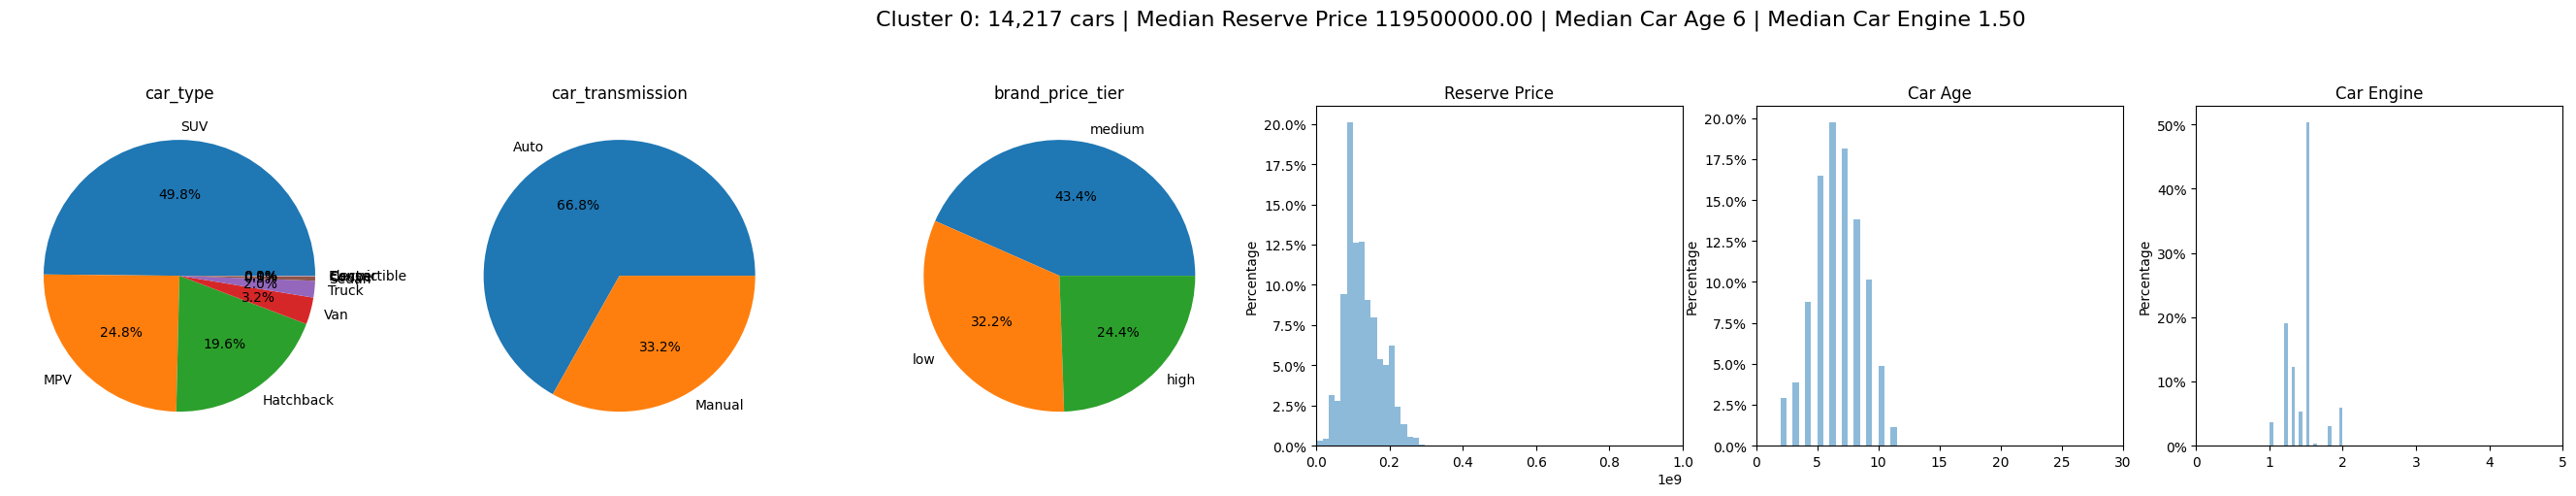

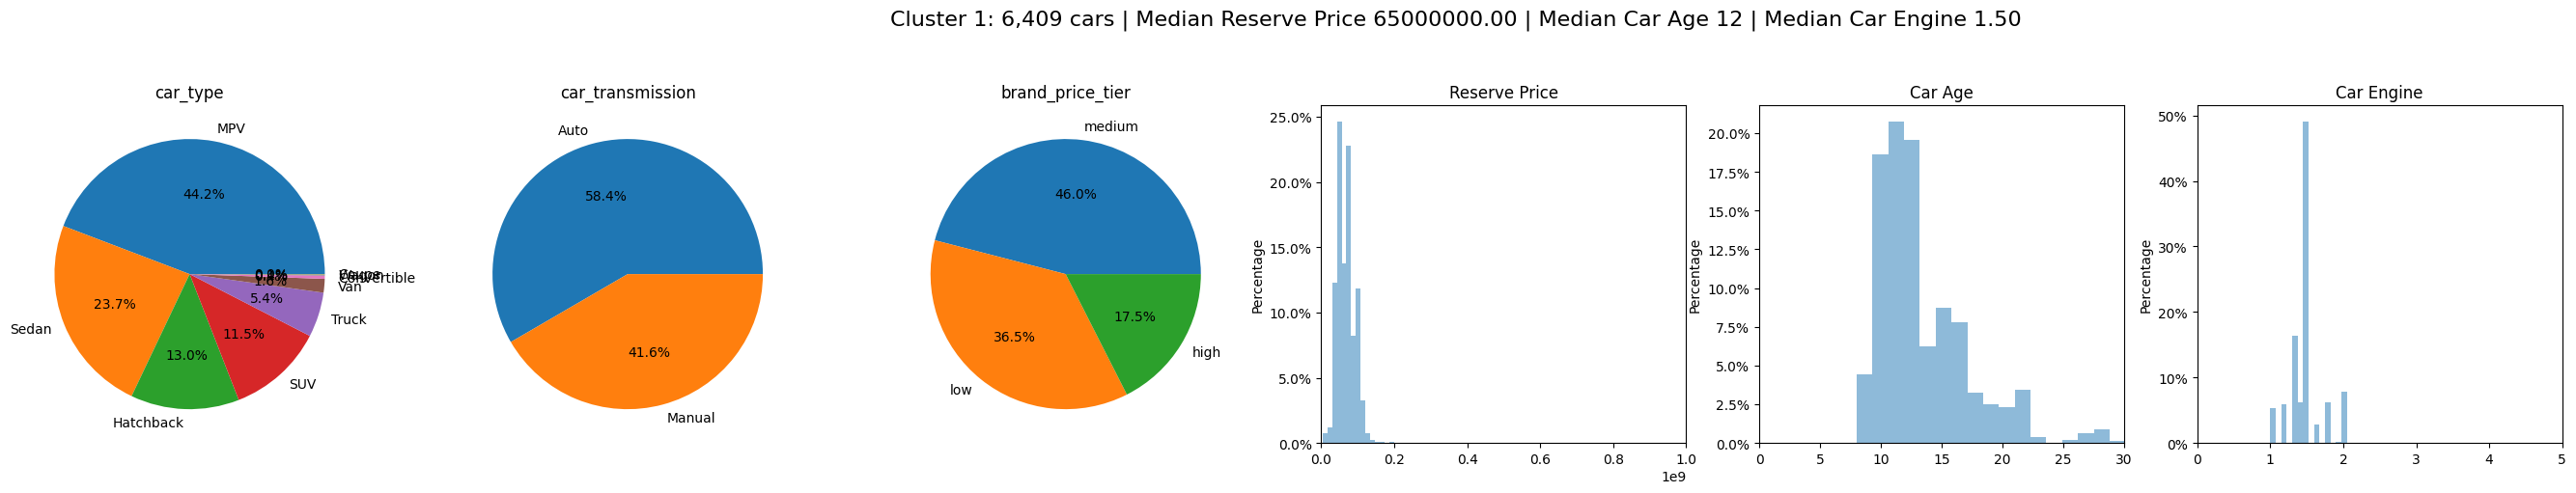

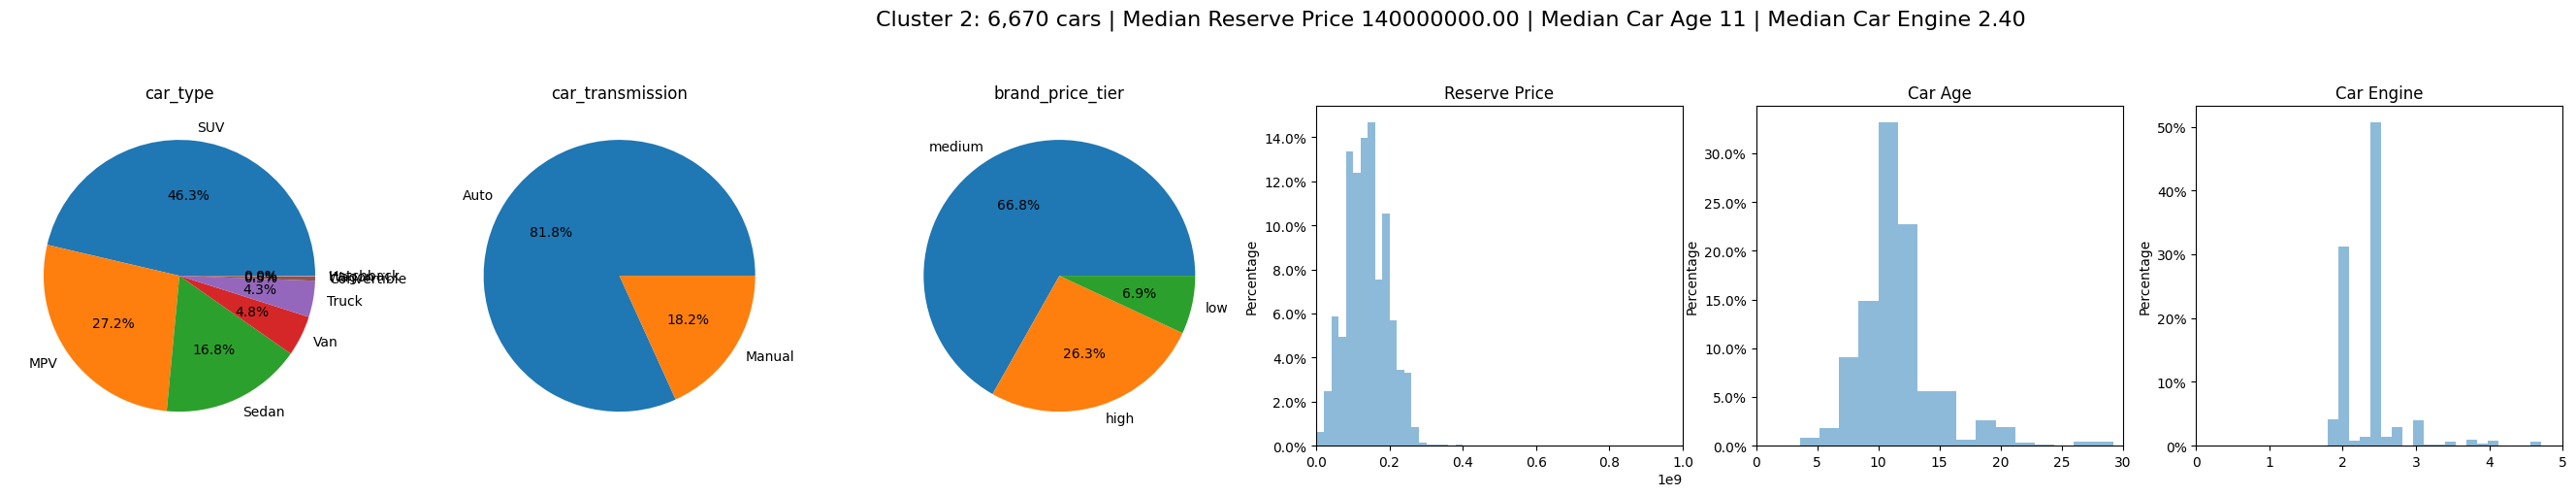

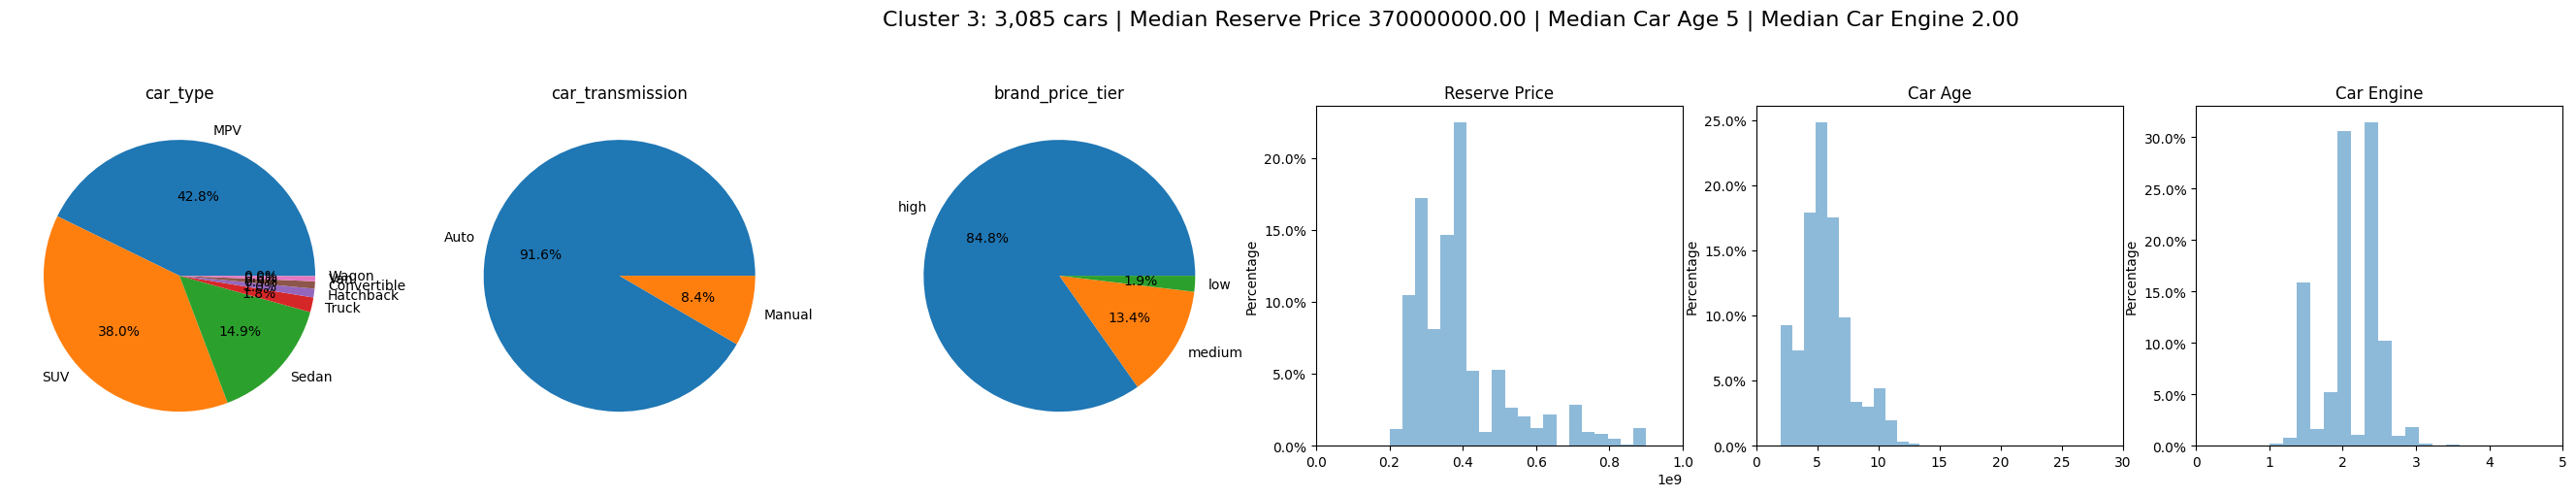

In [144]:
# helper function: medians and modes for each cluster
def cluster_profile(df):
    dfc = df.groupby("Cluster").agg({
        "reserveprice": "median",
        "car_age": "median",
        "car_engine": "median",
        "car_type": lambda x: x.value_counts().index[0],
        "car_transmission": lambda x: x.value_counts().index[0],
        "brand_price_tier": lambda x: x.value_counts().index[0]
                                    })  

    cluster_pies(df)
    return dfc

# call cluster profile function
cluster_profile(df_labeled).T

**Cluster 0**:   
This cluster comprises the largest percentage of cars (46.8%) where represented cars are predominantly SUVs, followed by MPVs and hatchbacks, and with automatic transmission and a medium price tier. The median reserve price is 119,500,000, which is lower than the median reserve prices of Clusters 2 and 3. The median age of the cars is 6 years, and ranging from 2 to 12 years. This cluster also has the lowest median car engine size at 1.5. Carsome could consider targeting this cluster for buyers who are looking for low-to-mid, relatively new, SUVs and MPVs. 

**Cluster 1**:   
This cluster has the second-highest number of cars, and the majority of them are MPVs, followed by sedans and hatchbacks, with both automatic and manual transmission options. The median reserve price is 65,000,000, which (like Cluster 0) is significantly lower than the median reserve prices of Clusters 2 and 3. The median car age is 12 years, which is the highest among all clusters. The median age of the cars in this cluster is 12 years, and the engine size is 1.5. This cluster has a relatively balanced distribution of transmission types, with slightly more automatic cars. Carsome could consider targeting this cluster for buyers who prefer MPVs and sedans with either transmission options, relatively lower prices and relatively older.

**Cluster 2**:   
This cluster represents cars that are predominantly SUVs and MPVs, with automatic transmission and a medium to high price tier. The median reserve price is 140,000,000, which is the highest among all clusters. The median age of the cars in this cluster is 11 years, which is higher than Cluster 0 but lower than Cluster 1. This cluster also has the largest median car engine size at 2.4. Carsome could consider targeting this cluster for customers who prefer SUVs and MPVs with automatic transmission, larger engines and are willing to pay a higher price for a relatively newer car.

**Cluster 3**:   
This cluster has the lowest number of cars. It represents cars that are predominantly MPVs and SUVs, with automatic transmission and a high price tier. The median reserve price is 370,000,000, which is significantly higher than the median reserve prices of Clusters 0 and 1. The median car age is 5 years, which is the lowest among all clusters. This cluster also has a high proportion of automatic cars and luxurious brands. Carsome could consider targeting this cluster for buyers who are looking for high-end, relatively new MPVs and SUVs from luxurious brands.

#### Classification Evaluation with Shap Plot

In [79]:
# Setting the objects to category 
cat_data = df_select.copy()
for i in cat_data.select_dtypes(include='object'):
    cat_data[i] = cat_data[i].astype('category')

In [80]:
# assigns the cluster labels generated by k-prototypes algorithm to proto_labs
proto_labs = kproto4.labels_

In [81]:
# create an instance of the LightGBM classifier with a specified value for colsample_by_tree parameter.
clf_kp = LGBMClassifier(colsample_by_tree=0.8)

# calculates the cross-validation F1 score for the k-prototypes clusters using the LightGBM classifier
cv_scores_kp = cross_val_score(clf_kp, cat_data, proto_labs, scoring='f1_weighted')
print(f'CV F1 score for K-Prototypes clusters is {np.mean(cv_scores_kp)}')

[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for K-Prototypes clusters is 0.9973663968314577


Our K-prototypes cluster model have F1 score (0.997) close to 1 which means that it has produced clusters that are easily distinguishable. 

In [82]:
# fit the LightGBM classifier on the categorical data and the cluster labels
clf_kp.fit(cat_data, proto_labs)

[LightGBM] [Warning] Unknown parameter: colsample_by_tree


LGBMClassifier(colsample_by_tree=0.8)

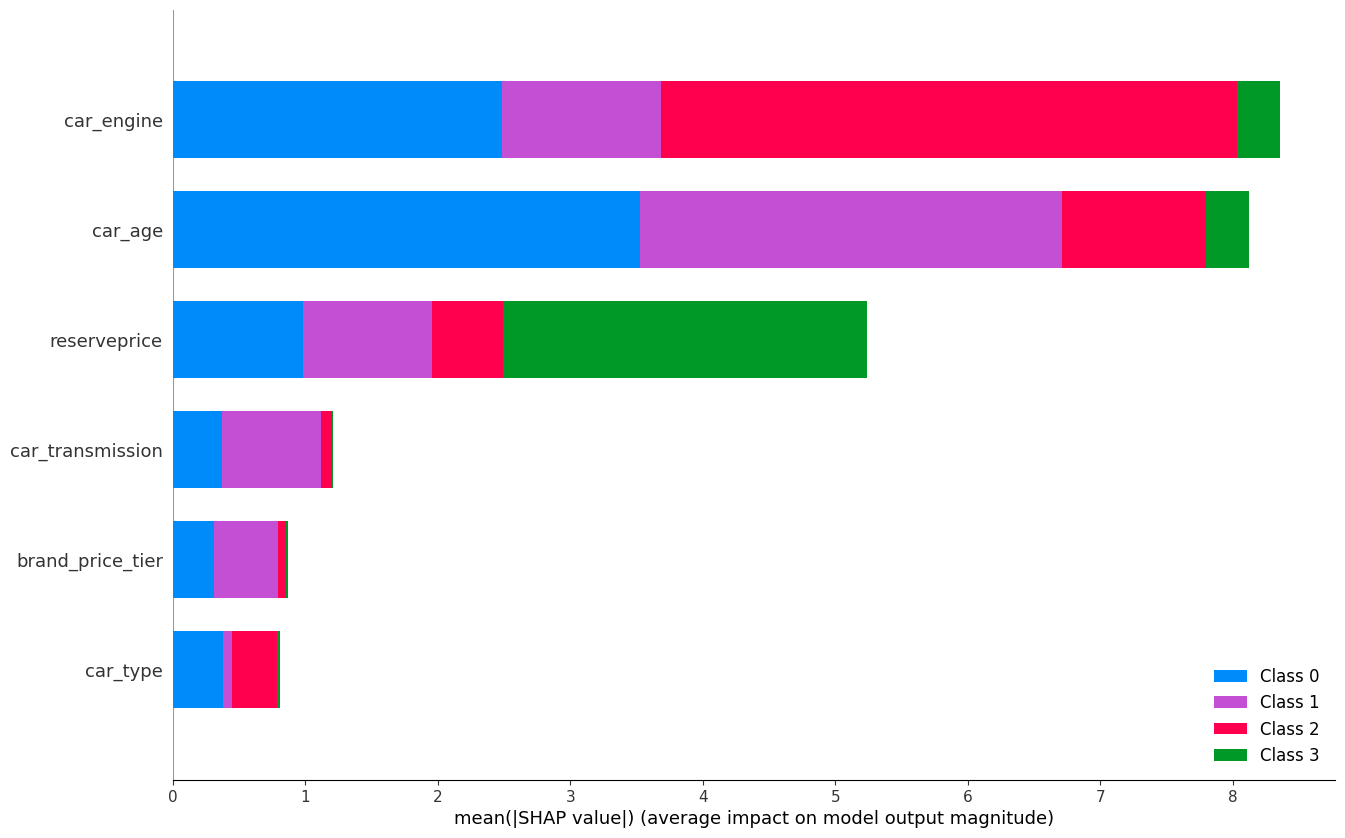

In [84]:
# create shap plot
explainer_kp = shap.TreeExplainer(clf_kp)
shap_values_kp = explainer_kp.shap_values(cat_data)

shap.summary_plot(shap_values_kp, cat_data, plot_type="bar", plot_size=(15, 10))

Shap plot affords a few insights as to which characteristics explained the most variance in separating out the groups.   
- car_engine and car_age was a heavy attribute for those in Cluster 0 (Class 0) 
- car_age played a lot into grouping members of Cluster 1 (Class 1) into that cluster
- car_engine was a heavy attribute for those in Cluster 2 (Class 2) 
- reserveprice pushed outcomes toward Cluster 3 (Class 3)


-   Cluster 0 (Class 0) is primarily characterized by cars with smaller engines and younger ages. This suggests that customers who are looking for more affordable cars may be drawn to this cluster.
-   Cluster 1 (Class 1) is characterized by older cars, regardless of engine size or car type. This suggests that customers who are looking for cheaper, more budget-friendly options may be drawn to this cluster.
-   Cluster 2 (Class 2) is primarily characterized by cars with larger engines, with a mix of car types. This suggests that customers who are looking for more powerful cars or specific car types may be drawn to this cluster.
-   Cluster 3 (Class 3) is characterized by high reserve prices, which suggests that these cars are more expensive and may appeal to customers who are looking for luxurious or high-end vehicles.

### Key Takeaways
Insightful insights that can be drawn from our analysis:
-  SUVs are popular among buyers, and automatic transmission is preferred over manual transmission.
-  Cars with smaller engines (1.5) are more popular and present in the majority of the clusters.
-  Cars that are relatively newer are preferred and can fetch a higher price, with the exception of the luxury cars in Cluster 3.
-  MPVs are popular across all clusters, except for Cluster 2, which has a higher percentage of SUVs.

These insights can be used by Carsome to optimize their car sourcing strategy. They can focus on sourcing cars that are in line with customer preferences, such as SUVs with automatic transmission and medium to high price tier. Furthermore, they may choose to focus on sourcing more affordable cars with smaller engines to meet the demand of customers who are budget-conscious. Additionally, the popularity of MPVs across all clusters suggests that sourcing MPVs can also be a viable option. Cluster 3 presents an opportunity for Carsome to acquire more higher-end luxurious cars, which can potentially fetch higher prices and appeal to customers who are looking for more expensive options.

### References

- https://towardsdatascience.com/one-hot-elbows-and-k-prototypes-more-customer-segmentation-in-python-106d13c55eae
- https://antonsruberts.github.io/kproto-audience/
